(multilevel-notebook)=
# Modelli multilivello

## Introduzione 

I modelli multilivello, noti anche come modelli gerarchici o a effetti misti, rappresentano una metodologia statistica potente e flessibile, particolarmente adatta per analizzare dati strutturati in più livelli. Questi modelli permettono di considerare simultaneamente variazioni a livelli diversi, come quello individuale e quello di gruppo, fornendo una comprensione più dettagliata e accurata dei fenomeni studiati.

In psicologia i modelli multilivello assumono un'importanza cruciale. Gli psicologi utilizzano  frequentemente dati raccolti in contesti complessi, dove gli effetti individuali e contestuali si intrecciano. Ad esempio, nella valutazione delle prestazioni cognitive o della risposta emotiva, i modelli multilivello consentono di distinguere tra variazioni dovute a caratteristiche individuali (come l'abilità cognitiva o la personalità) e quelle derivanti da fattori esterni (come l'ambiente scolastico o familiare).

I modelli multilivello sono particolarmente utili per:
- Analizzare dati longitudinali, dove le misurazioni ripetute sugli stessi soggetti introducono correlazioni naturali.
- Studiare l'impatto di fattori contestuali su variabili psicologiche, consentendo di esaminare come l'ambiente influenzi i comportamenti o gli stati mentali.
- Gestire la variabilità intra-individuale e inter-individuale in modo più efficace, offrendo una rappresentazione più realistica della complessità dei fenomeni psicologici.

In [1]:
source("../_common.R")

suppressPackageStartupMessages({
    library("rio")
    library("car")
    library("lme4")
    library("lavaan")
    library("semPlot")
    library("repr")
    library("kableExtra")
})
set.seed(42)

In questo capitolo, ci focalizzeremo sull'analisi di un'indagine sperimentale condotta per studiare l'impatto della deprivazione del sonno sulle prestazioni psicomotorie. I dati utilizzati provengono dallo studio di Belenky et al. (2003) sugli effetti della deprivazione del sonno. Questi dati sono accessibili nel dataset `sleepstudy`, incluso nel pacchetto `lme4` di R {cite:t}`bates2014fitting`.

Importiamo i dati.

In [2]:
data(sleepstudy)

Il data frame comprende 180 righe (osservazioni) e tre variabili:

- `Reaction`: Average reaction time (ms)
- `Days`: Number of days of sleep deprivation
- `Subject`: Subject number on which the observation was made.

Questi dati forniscono un esempio di dati multilivello, caratterizzati da misurazioni ripetute su una stessa variabile dipendente - in questo caso, il tempo medio di reazione (RT) - raccolte dai medesimi partecipanti per un periodo di dieci giorni. Tale struttura di dati è molto diffusa in psicologia, dove spesso si valutano le variazioni delle risposte o dei comportamenti di individui nel tempo.

Il dataset esaminato focalizza su diciotto partecipanti, sottoposti a una condizione di sonno limitato a tre ore. Nell'arco di dieci giorni, questi partecipanti hanno partecipato quotidianamente a un "test di vigilanza psicomotoria" della durata di dieci minuti. Durante il test, era richiesto loro di monitorare uno schermo e di premere un pulsante quanto più rapidamente possibile alla comparsa di uno stimolo. La variabile dipendente principale dello studio è il tempo medio di risposta (RT) di ciascun partecipante.

Per analizzare questi dati, è utile iniziare con una rappresentazione grafica. Se ci concentriamo sui dati di un singolo soggetto, questo ci permette di osservare le tendenze e le variazioni nel tempo di reazione di quel particolare individuo, fornendo insight su come la restrizione del sonno possa influire sulle sue prestazioni nel corso dei dieci giorni dello studio.

In [32]:
just_308 <- sleepstudy |>
    filter(Subject == "308")

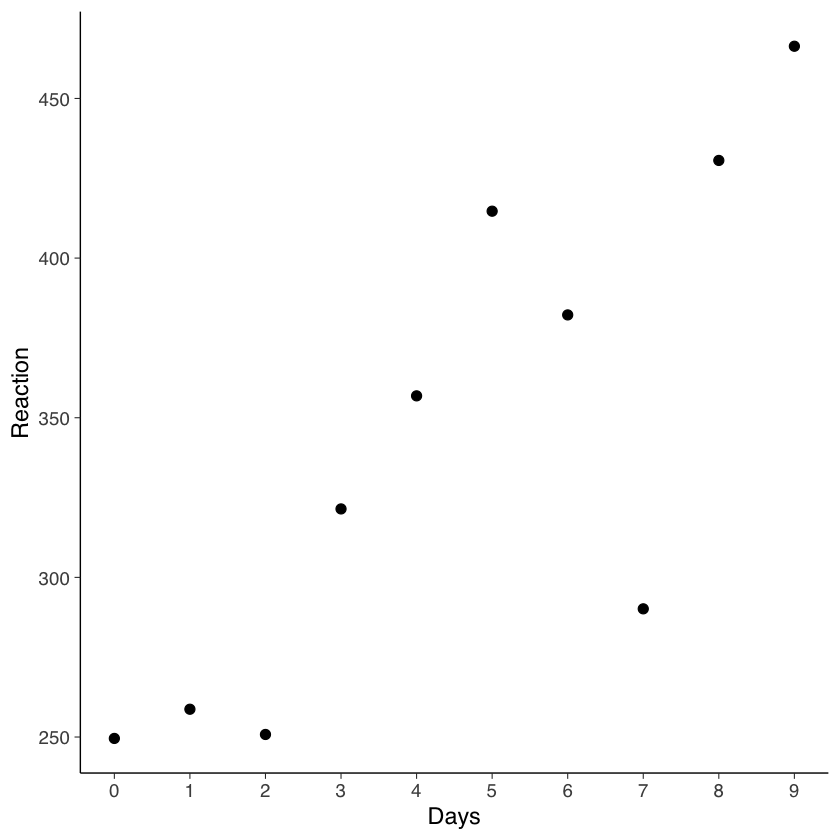

In [33]:
ggplot(just_308, aes(x = Days, y = Reaction)) +
    geom_point(size = 2.5) +
    scale_x_continuous(breaks = 0:9) 

Esaminiamo ora i dati di tutti i 18 soggetti.

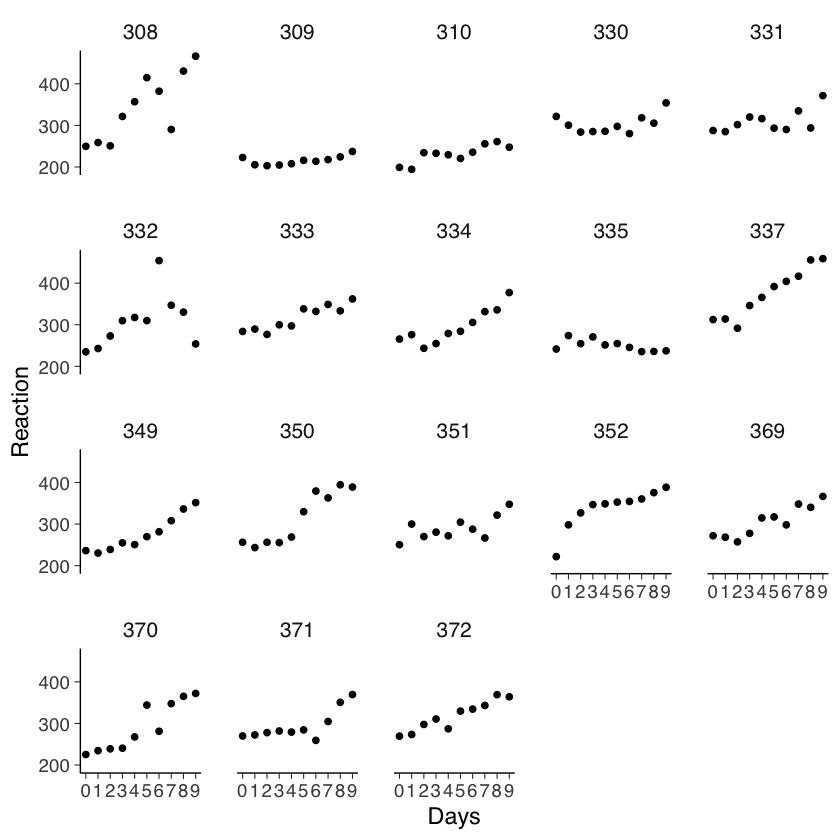

In [34]:
ggplot(sleepstudy, aes(x = Days, y = Reaction)) +
    geom_point() +
    scale_x_continuous(breaks = 0:9) +
    facet_wrap(~Subject)

#### Descrizione del Disegno Sperimentale
- **Fase di Adattamento e Baseline**: I primi tre giorni dello studio (T1, T2 e B) sono stati utilizzati per l'adattamento e l'addestramento (T1 e T2), seguiti da una misurazione baseline (B). Durante questo periodo, ai soggetti è stato chiesto di rimanere a letto per 8 ore (dalle 23:00 alle 07:00).
- **Condizioni di Sonno**: Dal quarto giorno in poi, per sette giorni (E1-E7), i soggetti hanno sperimentato diverse condizioni di sonno, variando la durata del tempo a letto (TIB) da 3 a 9 ore.

I primi due giorni (codificati come 0 e 1) sono stati dedicati all'adattamento e all'addestramento, mentre il terzo giorno (codificato come 2) ha visto la misurazione baseline. L'analisi dovrebbe idealmente partire dal giorno di baseline per riflettere l'effetto della restrizione del sonno sulle prestazioni. Per evitare che l'adattamento influenzi i risultati, i giorni 0 e 1 devono dunque essere esclusi dall'analisi, poiché qualsiasi variazione di prestazione in questi giorni è attribuibile all'addestramento piuttosto che alla restrizione del sonno.

#### Preparazione dei Dati
- **Rimozione delle Osservazioni Iniziali**: Dal dataset, eliminiamo le osservazioni dove la variabile "Days" è codificata come 0 o 1.
- **Creazione di una Nuova Variabile "days_deprived"**: Creiamo una nuova variabile basata su "Days", iniziando la sequenza dal giorno 2. In questa nuova variabile, il giorno 2 viene ricodificato come 0, il giorno 3 come 1, e così via. Questa variabile rappresenta il numero di giorni di privazione del sonno. Salviamo il dataset modificato con il nome `sleep2`, che ora riflette accuratamente il periodo di restrizione del sonno per l'analisi.

In [35]:
sleep2 <- sleepstudy |>
    filter(Days >= 2L) |>
    mutate(days_deprived = Days - 2L)

In [36]:
sleep2 |>
    count(days_deprived, Days)

days_deprived,Days,n
<dbl>,<dbl>,<int>
0,2,18
1,3,18
2,4,18
3,5,18
4,6,18
5,7,18
6,8,18
7,9,18


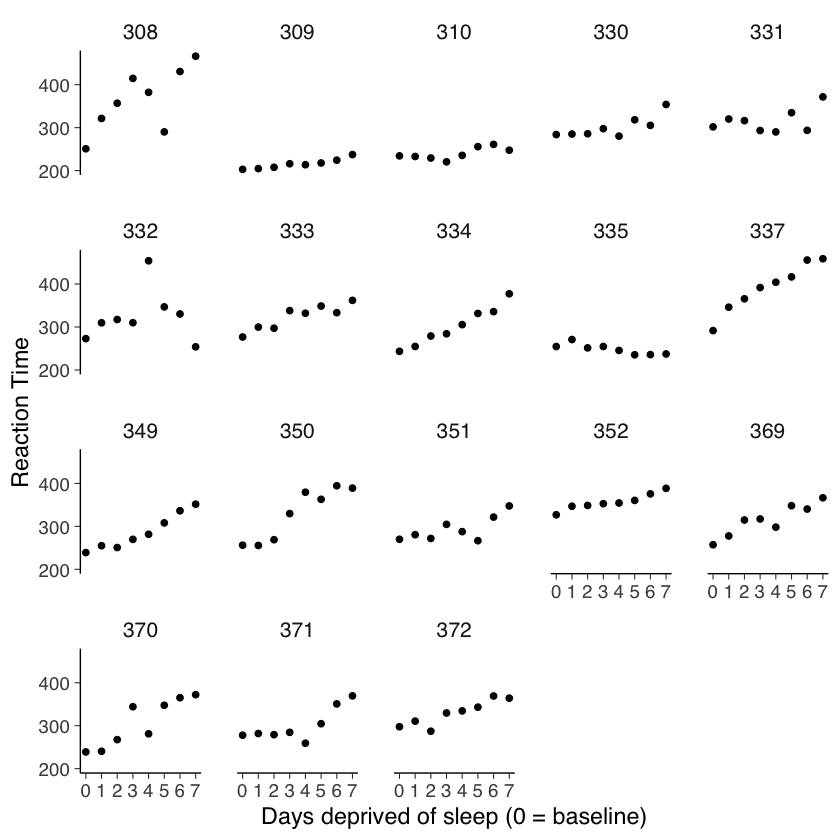

In [37]:
ggplot(sleep2, aes(x = days_deprived, y = Reaction)) +
    geom_point() +
    scale_x_continuous(breaks = 0:7) +
    facet_wrap(~Subject) +
    labs(y = "Reaction Time", x = "Days deprived of sleep (0 = baseline)")

### Analisi della Relazione tra Tempo di Reazione e Privazione del Sonno

Nel contesto dello studio sulla privazione del sonno, l'analisi dei dati suggerisce che, a parte una singola eccezione (il soggetto 335), il tempo di reazione medio tende ad aumentare progressivamente con ogni giorno aggiuntivo di privazione del sonno. Questo pattern indica che potrebbe essere utile descrivere le prestazioni di ciascun partecipante attraverso un modello di regressione lineare.

La regressione lineare è rappresentata dall'equazione generale:

$$ Y = \beta_0 + \beta_1 X, $$

dove $ Y $ è la variabile dipendente (in questo caso, il tempo di reazione), $ \beta_0 $ rappresenta l'intercetta (il tempo di reazione medio al giorno zero, prima dell'inizio della privazione del sonno) e $ \beta_1 $ è la pendenza (la variazione del tempo di reazione per ogni giorno aggiuntivo di privazione del sonno). Questi parametri ($ \beta_0 $ e $ \beta_1 $) sono stimati dai dati.

Quando si modellano i dati di ciascun partecipante, emergono diverse domande: dobbiamo adattare lo stesso modello di regressione lineare a tutti i partecipanti, o sarebbe più appropriato utilizzare un modello diverso per ogni soggetto? Oppure esiste un approccio intermedio che bilancia questi estremi?

Per rispondere a queste domande, esploriamo tre approcci differenti, come illustrato da {cite:t}`McElreath_rethinking`:

1. **Complete Pooling**: Questo approccio implica l'utilizzo di un unico modello di regressione lineare per tutti i partecipanti. Significa che assumiamo la stessa relazione lineare (stessa intercetta e pendenza) per tutti, ignorando le differenze individuali.

2. **No Pooling**: In questo approccio, ogni partecipante ha un proprio modello di regressione lineare individuale, con intercetta e pendenza uniche. Qui si riconosce che ogni individuo può rispondere diversamente alla privazione del sonno, e quindi il modello è personalizzato per ciascun soggetto.

3. **Partial Pooling**: Questo approccio intermedio cerca di bilanciare gli estremi dei due metodi precedenti. Include alcuni elementi comuni tra i soggetti (ad esempio, una pendenza media) ma permette anche una certa variazione individuale.

## Complete pooling

L'approccio di "complete pooling" in analisi statistica implica l'utilizzo di un modello che calcola un'unica intercetta e una sola pendenza per l'intero dataset. Questo metodo si basa sull'ipotesi che tutti i soggetti nel dataset condividano le stesse caratteristiche di base riguardo alla relazione tra la variabile dipendente e indipendente.

#### Caratteristiche del Complete Pooling
- **Unicità delle Stime**: Il modello stima un singolo set di parametri (intercetta e pendenza) per tutti i dati, considerando l'intero campione come un'unità omogenea.
- **Ignorare le Variazioni Individuali**: Questo approccio non tiene conto delle possibili differenze individuali nelle intercette o nelle pendenze tra i diversi soggetti. Ad esempio, ignorara come ciascun soggetto reagisce in modo diverso alla privazione del sonno.

#### Limitazioni dell'Approccio di Complete Pooling
Dall'analisi preliminare dei dati, abbiamo notato che l'approccio di complete pooling potrebbe non essere adatto per il nostro studio. La visualizzazione dei dati suggerisce che ogni partecipante potrebbe avere una propria relazione unica tra il tempo di reazione e i giorni di privazione del sonno, indicando la necessità di valori individuali per le intercette e le pendenze.

#### Modello di Regressione Lineare in Complete Pooling
Il modello generale lineare (GLM) per l'approccio di complete pooling è formulato come segue:

$$Y_{sd} = \beta_0 + \beta_1 X_{sd} + e_{sd},$$

dove:
- $ Y_{sd} $ rappresenta il tempo di reazione medio del soggetto $ s $ nel giorno $ d $.
- $ X_{sd} $ è il numero di giorni di privazione del sonno (variabile "days_deprived"), che varia da 0 a 7.
- $ e_{sd} $ è il termine di errore, che rappresenta le fluttuazioni casuali non spiegate dal modello.

#### Implementazione in R
Per adattare questo modello in R, si utilizza la funzione `lm()`:

In [39]:
cp_model <- lm(Reaction ~ days_deprived, sleep2)
summary(cp_model)


Call:
lm(formula = Reaction ~ days_deprived, data = sleep2)

Residuals:
     Min       1Q   Median       3Q      Max 
-112.284  -26.732    2.143   27.734  140.453 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    267.967      7.737  34.633  < 2e-16 ***
days_deprived   11.435      1.850   6.183 6.32e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 50.85 on 142 degrees of freedom
Multiple R-squared:  0.2121,	Adjusted R-squared:  0.2066 
F-statistic: 38.23 on 1 and 142 DF,  p-value: 6.316e-09


### Interpretazione del Modello di Regressione e Visualizzazione Grafica 

Il modello di regressione che abbiamo considerato offre una stima del tempo di risposta medio per i soggetti allo studio al Giorno 0 (prima della privazione del sonno) e la variazione media del tempo di risposta per ogni giorno aggiuntivo di privazione. Secondo questo modello, il tempo di risposta medio iniziale è stimato essere di circa 268 millisecondi, con un incremento medio di circa 11 millisecondi per ogni giorno successivo di privazione del sonno.

#### Considerazioni sui Limiti del Modello
È importante notare, tuttavia, che questo modello potrebbe avere delle limitazioni nella sua applicabilità:
- **Assunzione di Indipendenza**: Il modello assume che tutte le osservazioni siano indipendenti. Questa assunzione potrebbe non essere valida nel nostro studio, dato che le osservazioni provengono da misurazioni ripetute sugli stessi soggetti.
- **Errori Standard dei Coefficienti**: La presunta indipendenza delle osservazioni implica che gli errori standard dei coefficienti di regressione potrebbero non essere completamente affidabili.

#### Aggiunta delle Previsioni al Grafico
Per visualizzare meglio questi risultati, possiamo aggiungere le previsioni del modello al grafico che abbiamo già creato. Utilizziamo la funzione `geom_abline()` di R per tracciare la linea di regressione stimata direttamente sul grafico esistente:
- **Utilizzo di `geom_abline()`**: Questa funzione ci permette di aggiungere una linea di regressione al grafico, specificando l'intercetta e la pendenza.
- **Coefficienti del Modello**: Utilizziamo `coef(cp_model)` per ottenere i coefficienti di regressione (intercetta e pendenza) dal nostro modello. Questa funzione restituisce un vettore con due elementi corrispondenti all'intercetta e alla pendenza, che possono essere poi utilizzati per definire la linea nel grafico.

In conclusione, l'aggiunta delle previsioni del modello al grafico fornisce una rappresentazione visiva dell'effetto stimato della privazione del sonno sul tempo di risposta. Tuttavia, è essenziale tenere presente le limitazioni e le assunzioni del modello, in particolare l'indipendenza delle osservazioni, che potrebbe non essere una rappresentazione accurata dei dati nel contesto di misurazioni ripetute.

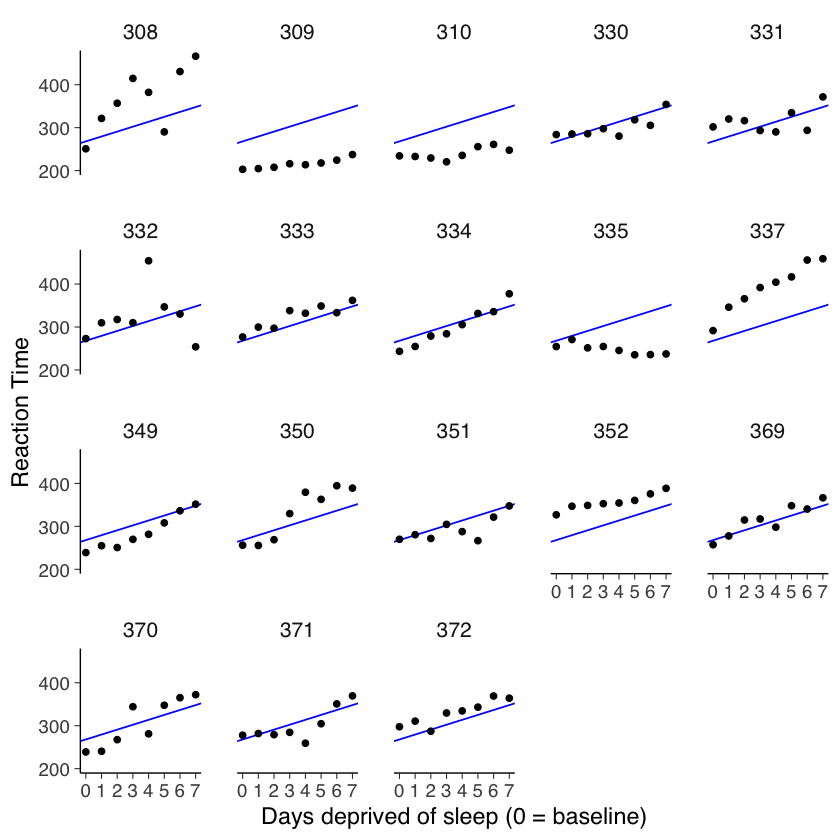

In [10]:
ggplot(sleep2, aes(x = days_deprived, y = Reaction)) +
    geom_abline(
        intercept = coef(cp_model)[1],
        slope = coef(cp_model)[2],
        color = "blue"
    ) +
    geom_point() +
    scale_x_continuous(breaks = 0:7) +
    facet_wrap(~Subject) +
    labs(y = "Reaction Time", x = "Days deprived of sleep (0 = baseline)")

Dall'analisi effettuata, emerge che il modello attuale non si adatta in modo ottimale ai dati raccolti. Questa situazione indica la necessità di esplorare un approccio diverso per modellare in modo più accurato le relazioni presenti nei dati.

## Approccio di No Pooling 

In alternativa al modello di "complete pooling", consideriamo l'approccio di "no pooling". Questo approccio si basa sull'idea di adattare modelli di regressione separati per ogni partecipante, trattando ogni individuo come un'entità distinta. 

### Caratteristiche del No Pooling
- **Indipendenza delle Stime**: In questo approccio, ogni partecipante ha il proprio set di stime per l'intercetta e la pendenza. Le stime relative a un partecipante non sono influenzate dalle stime degli altri.
- **Stime Individualizzate**: Si stima separatamente una coppia di intercetta/pendenza per ciascuno dei 18 partecipanti, riconoscendo la possibilità di variazioni significative nelle risposte individuali.

### Implementazione del Modello di No Pooling
Esistono due modi principali per implementare questo approccio:
1. **Regressioni Separate per Ogni Partecipante**: Eseguire una serie di regressioni lineari individuali, una per ogni soggetto.
2. **Modello di Regressione Unificato con Effetti Principali e Interazione**: Utilizzare un unico modello di regressione che includa sia gli effetti principali sia l'interazione tra le variabili `Subject` (soggetto) e `Day` (giorno). Questo metodo permette di includere tutte le stime in un unico modello.

Per il secondo approccio, è necessario considerare le seguenti fasi:
- **Creazione di Variabili Dummy per il Fattore `Subject`**: Poiché `Subject` ha 18 livelli, saranno necessarie 17 variabili dummy per rappresentare questi livelli. In R, questo può essere fatto automaticamente definendo `Subject` come un fattore.
- **Includere `Subject` come Fattore nel Modello**: Aggiungere `Subject`, definito come un fattore, come predittore nel modello. L'inclusione dell'interazione tra `Subject` e `days_deprived` permette variazioni nelle intercette e nelle pendenze tra i soggetti.

### Verifica del Fattore `Subject`
Prima di procedere, è importante assicurarsi che `Subject` sia definito correttamente come un fattore. Questo può essere verificato utilizzando la funzione `summary()` in R, che fornisce una sintesi delle caratteristiche della variabile, compreso se è trattata come un fattore.

In [40]:
sleep2 %>% 
    summary()

    Reaction          Days         Subject   days_deprived 
 Min.   :203.0   Min.   :2.00   308    : 8   Min.   :0.00  
 1st Qu.:265.2   1st Qu.:3.75   309    : 8   1st Qu.:1.75  
 Median :303.2   Median :5.50   310    : 8   Median :3.50  
 Mean   :308.0   Mean   :5.50   330    : 8   Mean   :3.50  
 3rd Qu.:347.7   3rd Qu.:7.25   331    : 8   3rd Qu.:5.25  
 Max.   :466.4   Max.   :9.00   332    : 8   Max.   :7.00  
                                (Other):96                 

La funzione `pull()` viene utilizzata per estrarre una specifica colonna da un data frame. Con le seguenti istruzioni verifichiamo se la colonna `Subject` è codificata come `factor`.

In [12]:
sleep2 |>
    pull(Subject) |>
    is.factor()

[1] TRUE

Adattiamo il modello di regressione ai dati. Si noti che la sintassi seguente può essere semplificata utilizzando `Reaction ~ days_deprived * Subject`.

In [41]:
np_model <- lm(Reaction ~ days_deprived + Subject + days_deprived:Subject,
    data = sleep2
)

summary(np_model)


Call:
lm(formula = Reaction ~ days_deprived + Subject + days_deprived:Subject, 
    data = sleep2)

Residuals:
     Min       1Q   Median       3Q      Max 
-106.521   -8.541    1.143    8.889  128.545 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              288.2175    16.4772  17.492  < 2e-16 ***
days_deprived             21.6905     3.9388   5.507 2.49e-07 ***
Subject309               -87.9262    23.3023  -3.773 0.000264 ***
Subject310               -62.2856    23.3023  -2.673 0.008685 ** 
Subject330               -14.9533    23.3023  -0.642 0.522422    
Subject331                 9.9658    23.3023   0.428 0.669740    
Subject332                27.8157    23.3023   1.194 0.235215    
Subject333                -2.7581    23.3023  -0.118 0.906000    
Subject334               -50.2051    23.3023  -2.155 0.033422 *  
Subject335               -25.3429    23.3023  -1.088 0.279207    
Subject337                24.6143    23.3023   1.056 0.

Per chiarire, il soggetto di riferimento è il 308; in R, la modalità predefinita è quella di ordinare i livelli del fattore in ordine alfabetico e di scegliere il primo come soggetto di riferimento. Questo significa che l'intercetta e la pendenza per il soggetto 308 sono rappresentate rispettivamente da `(Intercept)` e `days_deprived`, poiché tutte le altre 17 variabili dummy saranno nulle per il soggetto 308.

Tutti i coefficienti di regressione degli altri soggetti sono rappresentati come scostamenti da questo soggetto di riferimento. Se desideriamo calcolare l'intercetta e la pendenza per un dato soggetto, dobbiamo semplicemente sommare gli scostamenti corrispondenti. Pertanto, abbiamo:

Intercetta per 308: 288.217\
Pendenza per 308: 21.69

Intercetta per 335: `(Intercept) + Subject335` = 288.217 + -25.343 = 262.874\
Pendenza per 335: `days_deprived + days_deprived:Subject335` = 21.69 + -25.899 = -4.209

E così via.

Nel modello "no pooling", non viene stimata un'intercetta e una pendenza complessive per l'intera popolazione; in questo caso, `(Intercept)` e `days_deprived` sono stime dell'intercetta e della pendenza per il soggetto 308, che è stato scelto (arbitrariamente) come soggetto di riferimento. Per ottenere stime per l'intera popolazione, è possibile procedere con una seconda fase dell'analisi statistica in cui calcoliamo le medie delle intercette e delle pendenze individuali. 

In [47]:
coef(np_model) |> as.data.frame()

,coef(np_model)
,<dbl>
(Intercept),288.2174667
days_deprived,21.6904952
Subject309,-87.9262083
Subject310,-62.2856250
Subject330,-14.9532917
Subject331,9.9658167
Subject332,27.8157333
Subject333,-2.7581167
Subject334,-50.2051167


Calcoliamo le intercette individuali:

In [48]:
all_intercepts <- c(
    coef(np_model)["(Intercept)"],
    coef(np_model)[3:19] + coef(np_model)["(Intercept)"]
)

Calcliamo le pendenze individuali:

In [49]:
all_slopes <- c(
    coef(np_model)["days_deprived"],
    coef(np_model)[20:36] + coef(np_model)["days_deprived"]
)

Creiamo un DataFrame con le colonne Subject, intercept e slope:

In [50]:
ids <- sleep2 |>
    pull(Subject) |>
    levels() |>
    factor()
print(ids)

 [1] 308 309 310 330 331 332 333 334 335 337 349 350 351 352 369 370 371 372
18 Levels: 308 309 310 330 331 332 333 334 335 337 349 350 351 352 369 ... 372


In [52]:
# make a tibble with the data extracted above
np_coef <- tibble(
    Subject = ids,
    intercept = all_intercepts,
    slope = all_slopes
)

print(np_coef)

# A tibble: 18 x 3
   Subject intercept slope
   <fct>       <dbl> <dbl>
 1 308          288. 21.7 
 2 309          200.  4.36
 3 310          226.  3.90
 4 330          273.  8.01
 5 331          298.  4.87
 6 332          316.  2.40
 7 333          285. 10.9 
 8 334          238. 18.1 
 9 335          263. -4.21
10 337          313. 22.4 
11 349          229. 16.4 
12 350          248. 23.3 
13 351          264.  8.52
14 352          331.  7.29
15 369          267. 13.8 
16 370          235. 20.6 
17 371          258. 12.3 
18 372          291. 11.1 


Esaminiamo l'adattamento di questo modello ai dati.

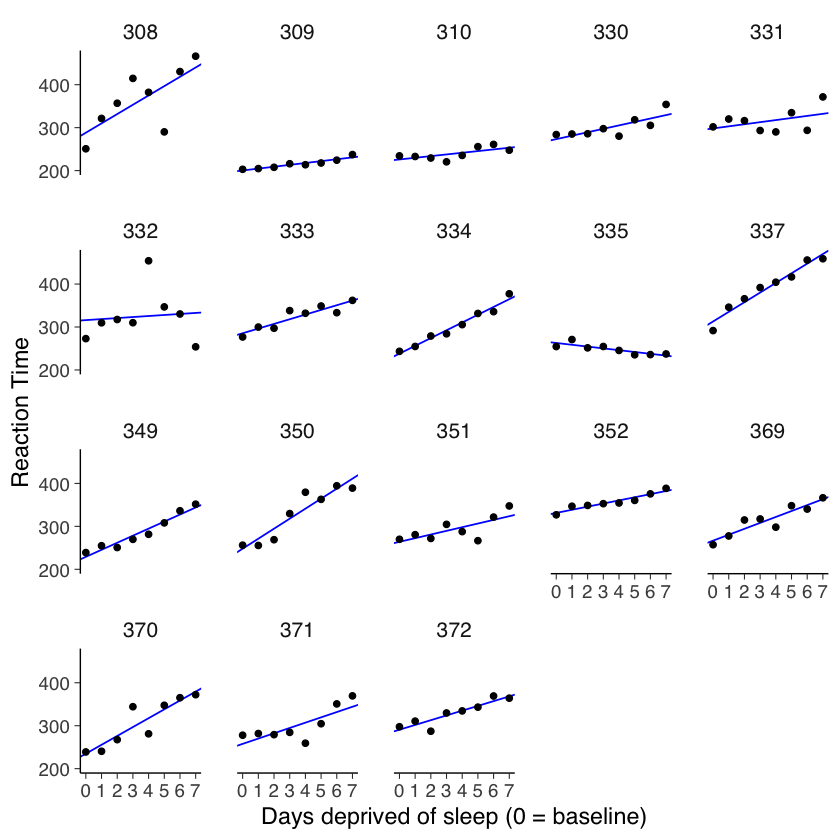

In [53]:
ggplot(sleep2, aes(x = days_deprived, y = Reaction)) +
    geom_abline(
        data = np_coef,
        mapping = aes(
            intercept = intercept,
            slope = slope
        ),
        color = "blue"
    ) +
    geom_point() +
    scale_x_continuous(breaks = 0:7) +
    facet_wrap(~Subject) +
    labs(y = "Reaction Time", x = "Days deprived of sleep (0 = baseline)")

Questa situazione è notevolmente migliorata rispetto al modello di pooling completo. Se desideriamo testare l'ipotesi nulla secondo cui la pendenza della retta di regressione è uguale a zero, possiamo farlo eseguendo un test $t$ di Student sul campione di pendenze individuali.

In [16]:
np_coef |>
    pull(slope) |>
    t.test()


	One Sample t-test

data:  pull(np_coef, slope)
t = 6.1971, df = 17, p-value = 9.749e-06
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
  7.542244 15.328613
sample estimates:
mean of x 
 11.43543 


Questo test suggerisce che la pendenza media di 11.435 è diversa da zero, t(17) = 6.20 p < .001.

## Approccio di Partial Pooling 

Nell'ambito dell'analisi dei dati psicologici, i ricercatori si trovano spesso a dover gestire un delicato equilibrio. Da un lato, vi è l'approccio di *complete pooling*, che tratta tutti i dati come se appartenessero a un unico gruppo omogeneo, e dall'altro, l'approccio di *no-pooling*, che considera i dati di ciascun soggetto in modo isolato, senza sfruttare le informazioni aggregate. Entrambi gli estremi hanno limitazioni significative: il *complete pooling* può mascherare le variazioni individuali, mentre il *no-pooling* può non sfruttare appieno le informazioni disponibili dall'intero set di dati.

Per superare queste limitazioni, emerge l'approccio di *partial pooling*. Questo metodo utilizza i modelli lineari a effetti misti, che rappresentano una via di mezzo tra i due estremi menzionati. Il *partial pooling* permette di trarre vantaggio dalle informazioni provenienti dall'insieme dei partecipanti, migliorando così le stime dei soggetti individuali. Attraverso questo approccio, si ottengono stime che non solo tengono conto delle peculiarità di ciascun individuo ma sono anche informate dalle tendenze generali osservate nel gruppo più ampio.

L'approccio di *partial pooling* permette di separare più efficacemente le tendenze generali dagli errori casuali in ciascun partecipante e si dimostra più adatto per generalizzare i risultati a una popolazione più ampia, al di là dei soggetti specifici coinvolti nello studio.

### Implementazione dei Modelli a Effetti Misti
- **Trattare i Soggetti come Fattori Casuali**: Nel *partial pooling*, i soggetti vengono considerati come un fattore casuale anziché fisso. Ciò implica che i livelli del fattore (i soggetti nel nostro caso) sono visti come un campione casuale da una popolazione più ampia.
- **Modello Lineare a Effetti Misti**: Questo tipo di modello statistico consente di includere i fattori casuali nell'analisi. In un modello misto, le stime per ogni soggetto sono "informate" o influenzate dalle informazioni aggregate degli altri soggetti.
- **Shrinkage o Restringimento**: Il fenomeno dello *shrinkage* indica che le stime per ciascun soggetto vengono regolate o "spostate" verso le stime medie della popolazione, permettendo una valutazione più equilibrata e meno influenzata da variazioni estreme o casuali.

### Articolazione e Applicazione del Modello Multilivello

Il modello multilivello che analizziamo è strutturato per cogliere le relazioni dinamiche tra variabili a livelli diversi. Esaminiamo i dettagli di ogni livello e il loro significato nel contesto del modello.

#### Livello 1: Modellazione della Relazione Individuale
Il primo livello del modello esprime la relazione lineare individuale tra la variabile di risposta (tempo di reazione) e i predittori (giorni di privazione del sonno):

$$
Y_{sd} = \beta_{0s} + \beta_{1s} X_{sd} + e_{sd},
$$

dove $Y_{sd}$ è il tempo di reazione del soggetto $s$ al giorno $d$, $\beta_{0s}$ e $\beta_{1s}$ sono i parametri individuali di intercetta e pendenza, e $e_{sd}$ rappresenta l'errore per ogni soggetto e giorno. I parametri $\beta_{0s}$ e $\beta_{1s}$ sono considerati derivati, poiché dipendono dalle variabili a Livello 2.

#### Livello 2: Modellazione delle Variazioni Tra Soggetti
Al secondo livello, definiamo come l'intercetta e la pendenza cambiano tra i soggetti:

$$
\beta_{0s} = \gamma_{0} + S_{0s},
$$ 

$$
\beta_{1s} = \gamma_{1} + S_{1s}.
$$

Qui, $\gamma_0$ e $\gamma_1$ sono gli effetti fissi che rappresentano l'intercetta e la pendenza medie della popolazione, mentre $S_{0s}$ e $S_{1s}$ sono gli effetti casuali che permettono variazioni individuali.

#### Componenti di Varianza
Le componenti di varianza nel modello sono espresse come:

$$
\langle S_{0s}, S_{1s} \rangle \sim N(\langle 0, 0 \rangle, \mathbf{\Sigma}),
$$

$$
\mathbf{\Sigma} = \begin{pmatrix}{\tau_{00}}^2 & \rho\tau_{00}\tau_{11} \\ \rho\tau_{00}\tau_{11} & {\tau_{11}}^2 \end{pmatrix},
$$

$$
e_{sd} \sim N(0, \sigma^2).
$$

La matrice $\mathbf{\Sigma}$ determina la distribuzione degli effetti casuali, con ${\tau_{00}}^2$ e ${\tau_{11}}^2$ che indicano le varianze delle intercette e delle pendenze casuali, mentre $\rho$ è la correlazione tra questi effetti.

#### Interpretazione Complessiva del Modello
Unendo le equazioni di Livello 1 e Livello 2, otteniamo una visione completa del modello:

$$
Y_{sd} = \gamma_0 + S_{0s} + (\gamma_1 + S_{1s}) X_{sd} + e_{sd},
$$

dove

- $ Y_{sd} $: È il valore osservato della variabile di risposta per il soggetto $ s $ al giorno $ d $.
- $ \gamma_0 $ e $ \gamma_1 $: Sono gli effetti fissi. $ \gamma_0 $ rappresenta l'intercetta generale, ovvero la media della popolazione per la variabile di risposta quando la variabile predittiva $ X $ è zero. $ \gamma_1 $ rappresenta la pendenza generale, che indica come la variabile di risposta cambia in media con un'unità di incremento della variabile predittiva $ X $.
- $ S_{0s} $ e $ S_{1s} $: Sono gli effetti casuali. $ S_{0s} $ è l'effetto casuale dell'intercetta per il soggetto $ s $, mentre $ S_{1s} $ è l'effetto casuale della pendenza. Questi termini rappresentano come ciascun soggetto si discosta dalla media della popolazione.
- $ X_{sd} $: È la variabile predittiva per il soggetto $ s $ al giorno $ d $.
- $ e_{sd} $: È l'errore casuale associato a ciascuna osservazione.

#### Interpretazione degli Effetti Fissi e Casuali
- Gli effetti fissi ($ \gamma_0 $ e $ \gamma_1 $) sono costanti per tutti i soggetti e riflettono le caratteristiche della popolazione generale.
- Gli effetti casuali ($ S_{0s} $ e $ S_{1s} $) variano da soggetto a soggetto e sono modellati come distribuzioni normali centrate attorno a zero. Questo significa che la distribuzione degli effetti casuali è centrata attorno agli effetti fissi della popolazione.

#### Uso di Campioni per Informare sulla Popolazione
Trattare i soggetti come variabili casuali anziché fisse ci consente di usare i dati del campione per inferire sulla popolazione più ampia. Invece di stimare valori specifici per ogni soggetto, il modello stima la distribuzione da cui questi valori sono estratti, fornendo una visione più generalizzata e applicabile a livello di popolazione.

### Spiegazione della Matrice di Varianza-Covarianza nel Modello Multilivello

La matrice di varianza-covarianza nel modello multilivello gioca un ruolo cruciale nel definire come gli effetti casuali variano e sono correlati tra loro all'interno della popolazione studiata. Questa matrice è rappresentata come segue:

$$
\Sigma = 
\begin{pmatrix}
\tau_{00}^2 & \rho \tau_{00} \tau_{11} \\
\rho \tau_{00} \tau_{11} & \tau_{11}^2
\end{pmatrix},
$$

dove $\Sigma$ denota la matrice di varianza-covarianza per gli effetti casuali $\langle S_{0s}, S_{1s} \rangle$, che sono modellati come normalmente distribuiti con una media di zero e una varianza-covarianza data da $\Sigma$.

#### Componenti della Matrice
- **Varianze degli Effetti Casuali**: 
  - $\tau_{00}^2$: Varianza dell'effetto casuale sull'intercetta ($S_{0s}$). Questo parametro indica quanto i soggetti differiscono nella loro reazione iniziale (tempo di reazione al Giorno 0) prima di qualsiasi privazione del sonno.
  - $\tau_{11}^2$: Varianza dell'effetto casuale sulla pendenza ($S_{1s}$). Misura la variazione tra i soggetti nella loro reattività agli effetti della privazione del sonno.

- **Covarianze**: 
  - $\rho \tau_{00} \tau_{11}$: Covarianza tra l'intercetta e la pendenza casuali. Questo termine riflette come la reazione iniziale di un soggetto (intercetta) sia correlata con la variazione della sua reattività al sonno (pendenza). Un valore positivo di $\rho$ indica che soggetti con un tempo di reazione inizialmente più lento tendono a mostrare un aumento più marcato del tempo di reazione con la privazione del sonno, e viceversa.

#### Significato e Importanza di $\Sigma$
- **Distribuzione degli Effetti Casuali**: La matrice $\Sigma$ determina le probabilità di estrarre una coppia specifica di effetti casuali ($S_{0s}, S_{1s}$) per un soggetto dal pool più ampio della popolazione.
- **Analisi delle Variazioni Individuali**: Attraverso $\Sigma$, possiamo comprendere meglio quanto e in che modo i soggetti variano sia nella loro reazione iniziale sia nella loro risposta alla privazione del sonno.
- **Interpretazione dei Risultati**: La comprensione di $\Sigma$ aiuta a interpretare i risultati del modello in termini di varianza e covarianza tra i soggetti, permettendo di trarre conclusioni più precise sulla popolazione studiata.

La matrice di varianza-covarianza $\Sigma$ è fondamentale nel modello multilivello perché fornisce un quadro dettagliato della varianza e della covarianza degli effetti casuali, consentendo di cogliere le sottili variazioni e correlazioni tra i soggetti. Questa comprensione arricchisce l'analisi e rende possibili conclusioni più accurate sulla popolazione.

### Tabella delle Variabili

| Variabile               | Tipo      | Descrizione                                                           |
|-------------------------|-----------|----------------------------------------------------------------------|
| $Y_{sd}$              | Osservata | Valore di `Reaction` per il soggetto $s$ al giorno $d$          |
| $X_{sd}$              | Osservata | Valore di `days_deprived` (0-7) per il soggetto $s$ al giorno $d$|
| $\beta_{0s}$          | Derivata  | Parametro di intercetta di livello 1 per il soggetto $s$           |
| $\beta_{1s}$          | Derivata  | Parametro di pendenza di livello 1 per il soggetto $s$            |
| $e_{sd}$              | Derivata  | Errore per il soggetto $s$ al giorno $d$                         |
| $\gamma_0$            | Fissa     | Intersezione generale (media di $\beta_{0s}$ nella popolazione)    |
| $\gamma_1$            | Fissa     | Pendenza generale (media di $\beta_{1s}$ nella popolazione)       |
| $S_{0s}$              | Casuale   | Effetto random di intercetta per il soggetto $s$                  |
| $S_{1s}$              | Casuale   | Effetto random di pendenza per il soggetto $s$                    |
| $\mathbf{\Sigma}$     | Casuale   | Matrice di varianza-covarianza                                      |
| ${\tau_{00}}^2$       | Casuale   | Varianza degli effetti random di intercetta                         |
| $\rho$                | Casuale   | Correlazione tra intercetta e pendenza                              |
| ${\tau_{11}}^2$       | Casuale   | Varianza degli effetti random di pendenza                           |
| $\sigma^2$            | Casuale   | Varianza dell'errore                                                |

#### Spiegazione delle Categorie di Variabili nel Modello Multilivello

Nella tabella delle variabili del modello multilivello, utilizziamo tre categorie specifiche per classificare le diverse variabili: *fisso*, *casuale* e *derivato*. Queste categorie ci aiutano a comprendere il ruolo e la natura di ciascuna variabile all'interno del modello:

##### Variabili Fisse
- **Definizione**: Le variabili fisse sono quelle che assumiamo costanti attraverso il campione e la popolazione. Sono parametri che rappresentano le caratteristiche generali della popolazione da cui il campione è tratto.
- **Esempi**: Nella tabella, $\gamma_0$ (intercetta generale) e $\gamma_1$ (pendenza generale) sono variabili fisse.
- **Ruolo nel Modello**: Riflettono le tendenze centrali o gli effetti medi nella popolazione oggetto di studio.

##### Variabili Casuali
- **Definizione**: Le variabili casuali indicano i parametri che possono variare tra i soggetti o altre unità di analisi. Questi parametri sono concepiti come estratti da una distribuzione più ampia.
- **Esempi**: $S_{0s}$ (intercetta casuale per soggetto) e $S_{1s}$ (pendenza casuale per soggetto) sono esempi di variabili casuali.
- **Ruolo nel Modello**: Consentono di modellare e comprendere la varianza e la covarianza all'interno del campione, riflettendo la variabilità individuale o di gruppo.

##### Variabili Derivate
- **Definizione**: 'Derivato' non è un termine standard nella modellistica statistica, ma lo utilizziamo qui per distinguere le variabili che non sono direttamente stimabili, ma piuttosto calcolate o derivate da altre variabili nel modello.
- **Esempi**: $\beta_{0s}$ (intercetta di livello 1 per soggetto) e $\beta_{1s}$ (pendenza di livello 1 per soggetto) sono variabili derivate, calcolate combinando variabili fisse e casuali.
- **Ruolo nel Modello**: Le variabili derivate rappresentano i parametri specifici per ciascun soggetto o unità di analisi, derivati dalla combinazione delle influenze fisse e casuali.

In conclusione, il modello misto permette di tenere conto della variazione sia a livello di popolazione sia a livello individuale. Questa capacità di distinguere tra variazioni generali e specifiche dei soggetti è cruciale in molte situazioni, come quando si analizzano effetti di trattamenti o condizioni sperimentali diverse su gruppi di soggetti.

## Stimare i parametri del modello

Per stimare i parametri del modello usando R, utilizzeremo la funzione `lmer()` del pacchetto `lme4` {cite:t}`bates2014fitting`. Questa funzione permette di specificare sia i fattori fissi (come i giorni di deprivazione del sonno) sia i fattori casuali (come i soggetti), ottenendo un modello che bilancia efficacemente le informazioni individuali con quelle aggregate.

La sintassi base di `lmer()` è la seguente:

$$ \text{lmer(formula, data, ...)}, $$

dove formula esprime la struttura del modello sottostante in un formato compatto e data è il data frame in cui si trovano le variabili menzionate nella formula.

Il formato generale della formula del modello per N effetti fissi (fix) e K effetti casuali (ran) è:

$$ \text{DV ~ fix1 + fix2 + ... + fixN + (ran1 + ran2 + ... + ranK | random\_factor1)} $$

Le interazioni tra i fattori A e B possono essere specificate utilizzando sia A * B (interazione ed effetti principali) che A:B (solo l'interazione).

Una differenza chiave dalla sintassi standard dei modelli R è la presenza di un termine di effetto casuale, racchiuso tra parentesi, ad esempio `(ran1 + ran2 + ... + ranK | random_factor)`. Ogni espressione tra parentesi rappresenta gli effetti casuali associati a un singolo fattore casuale. È possibile avere più di un termine di effetti casuali in una singola formula (fattori casuali incrociati). I termini relativi agli effetti casuali forniscono istruzioni a `lmer()` su come costruire le matrici di varianza-covarianza.

Sul lato sinistro della barra `|` vengono elencati gli effetti che vogliamo fare variare tra i livelli del fattore casuale indicato sul lato destro. Di solito, la variabile sul lato destro è una variabile che identifica i soggetti (ad esempio, `subject_id`).

Consideriamo le seguenti possibili formule di modello per i dati `sleep2` e le matrici di varianza-covarianza che esse costruiscono.

| model                            | syntax                                                 |
|----------------------------------|--------------------------------------------------------|
| 1. random intercepts only           | Reaction ~ days_deprived + (1 \| Subject)              |
| 2. random intercepts and slopes     | Reaction ~ days_deprived + (1 + days_deprived \| Subject) |
| 3. model 2 alternate syntax        | Reaction ~ days_deprived + (days_deprived \| Subject)   |
| 4. random slopes only              | Reaction ~ days_deprived + (0 + days_deprived \| Subject) |
| 5. model 2 + zero-covariances      | Reaction ~ days_deprived + (days_deprived \|\| Subject) |

Modello 1:

$$ \mathbf{\Sigma} =
\begin{pmatrix}
\tau_{00}^2 & 0 \\
0 & 0
\end{pmatrix}
$$ 

Modelli 2 e 3:

$$  \mathbf{\Sigma} =
\begin{pmatrix}
\tau_{00}^2 & \rho \tau_{00} \tau_{11} \\
\rho \tau_{00} \tau_{11} & \tau_{11}^2
\end{pmatrix}
$$ 

Modello 4:

$$  \mathbf{\Sigma} =
\begin{pmatrix}
0 & 0 \\
0 & \tau_{11}^2
\end{pmatrix}
$$ 

Modello 5:

$$  \mathbf{\Sigma} =
\begin{pmatrix}
\tau_{00}^2 & 0 \\
0 & \tau_{11}^2
\end{pmatrix}
$$ 

Il modello più ragionevole per i dati dell'esempio è il Modello 2, quindi useremo quello.

In [54]:
pp_mod <- lmer(
    Reaction ~ 1 + days_deprived + (1 + days_deprived | Subject), 
    data = sleep2
)
summary(pp_mod)

Linear mixed model fit by REML ['lmerMod']
Formula: Reaction ~ 1 + days_deprived + (1 + days_deprived | Subject)
   Data: sleep2

REML criterion at convergence: 1404.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0157 -0.3541  0.0069  0.4681  5.0732 

Random effects:
 Groups   Name          Variance Std.Dev. Corr
 Subject  (Intercept)   958.35   30.957       
          days_deprived  45.78    6.766   0.18
 Residual               651.60   25.526       
Number of obs: 144, groups:  Subject, 18

Fixed effects:
              Estimate Std. Error t value
(Intercept)    267.967      8.266  32.418
days_deprived   11.435      1.845   6.197

Correlation of Fixed Effects:
            (Intr)
days_deprvd -0.062

Prima di discutere come interpretare l'output, iniziamo col rappresentare graficamente i dati rispetto alle previsioni del nostro modello. Possiamo ottenere le previsioni del modello utilizzando la funzione `predict()` (vedi `?predict.merMod` per informazioni sull'uso con modelli a effetti misti).

Per prima cosa, creaiamo un nuovo dataframe con i valori dei predittori per `Subject` e `days_deprived`.

In [55]:
head(sleep2)

,Reaction,Days,Subject,days_deprived
,<dbl>,<dbl>,<fct>,<dbl>
1,250.8006,2,308,0
2,321.4398,3,308,1
3,356.8519,4,308,2
4,414.6901,5,308,3
5,382.2038,6,308,4
6,290.1486,7,308,5


In [18]:
newdata <- crossing(
    Subject = sleep2 |> 
    pull(Subject) |> 
    levels() |> 
    factor(),
    days_deprived = 0:7
)

head(newdata, 17)

Subject,days_deprived
<fct>,<int>
308,0
308,1
308,2
308,3
308,4
308,5
308,6
308,7
309,0


Il codice precedente crea un nuovo data frame chiamato `newdata` utilizzando la funzione `crossing()` da `dplyr`. 

`Subject = sleep2 |> pull(Subject) |> levels() |> factor()`: Questa parte del codice estrae la colonna "Subject" dal data frame "sleep2", quindi applica una serie di operazioni successive utilizzando l'operatore `|>` (pipe) per manipolare i dati nella colonna. 
   - `sleep2 |> pull(Subject)`: Inizia estraendo la colonna "Subject" dal data frame "sleep2".
   - `levels()`: Successivamente, applica la funzione "levels()" per ottenere i livelli unici della colonna "Subject". Questo è utile quando si ha a che fare con variabili categoriche (come un "factor").
   - `factor()`: Infine, trasforma i livelli ottenuti in un "factor". Questo è importante perché la funzione "crossing()" richiede che le variabili categoriche siano di tipo "factor".

1. `days_deprived = 0:7`: Questa parte del codice crea una nuova variabile chiamata "days_deprived" che contiene una sequenza da 0 a 7. Questo rappresenta i giorni di privazione.

2. `crossing(...)`: Infine, la funzione "crossing()" viene utilizzata per creare un nuovo data frame chiamato "newdata" combinando tutte le possibili combinazioni di valori tra la variabile "Subject" (con i suoi livelli unici) e la variabile "days_deprived" (con i valori da 0 a 7). 

Utilizziamo `predict()` per trovare le rette di regressione per ciascun soggetto.

In [19]:
newdata2 <- newdata |>
    mutate(Reaction = predict(pp_mod, newdata))

In [56]:
head(newdata2)

Subject,days_deprived,Reaction
<fct>,<int>,<dbl>
308,0,292.4667
308,1,312.5041
308,2,332.5416
308,3,352.5790
308,4,372.6164
308,5,392.6539


Ora possiamo creare il grafico con le predizioni del modello.

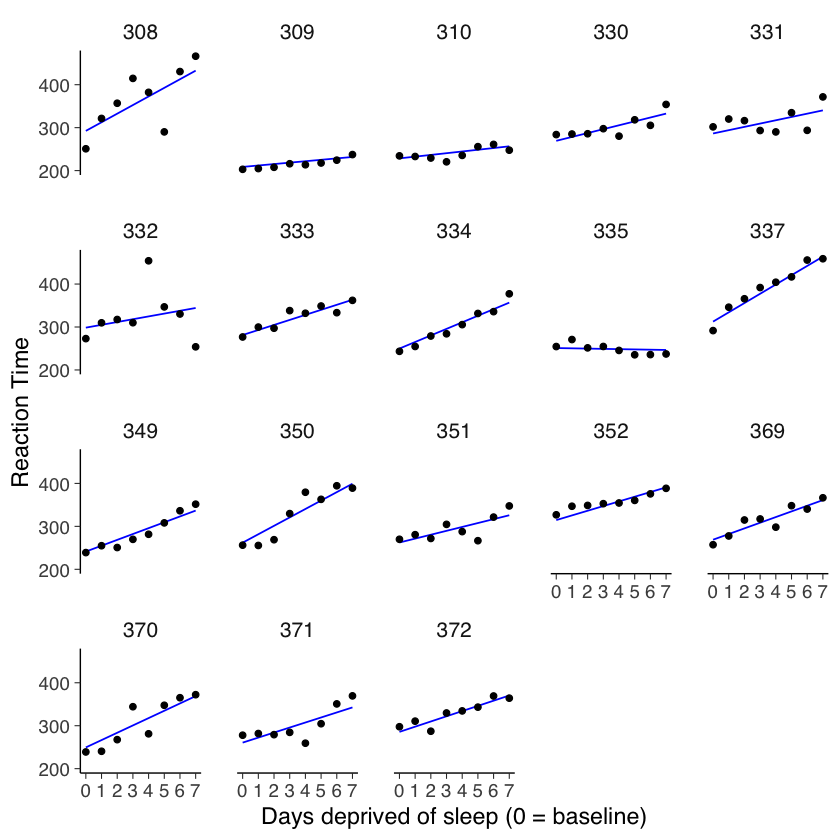

In [20]:
ggplot(sleep2, aes(x = days_deprived, y = Reaction)) +
    geom_line(
        data = newdata2,
        color = "blue"
    ) +
    geom_point() +
    scale_x_continuous(breaks = 0:7) +
    facet_wrap(~Subject) +
    labs(y = "Reaction Time", x = "Days deprived of sleep (0 = baseline)")

## Interpretare l'output di `lmer()` ed estrarre le stime

La chiamata a `lmer()` restituisce un oggetto della classe "lmerMod". 

### Effetti fissi

La sezione dell'output chiamata "Effetti fissi:" è simile a ciò che si vede nell'output per un modello lineare semplice adattato con `lm()`.

```
Fixed effects:
              Estimate Std. Error t value
(Intercept)    267.967      8.266  32.418
days_deprived   11.435      1.845   6.197
```

L'output precedente indica che il tempo di reazione medio stimato per i partecipanti al Giorno 0 era di circa 268 millisecondi, con ogni giorno di privazione del sonno che aggiungeva mediamente ulteriori 11 millisecondi al tempo di risposta.

Se dobbiamo ottenere gli effetti fissi dal modello, possiamo estrarli utilizzando la funzione `fixef()`.

In [57]:
fixef(pp_mod) |> 
    print()

  (Intercept) days_deprived 
    267.96742      11.43543 


Gli errori standard ci forniscono stime della variabilità di questi parametri dovuta all'errore di campionamento. Possiamo utilizzarli per calcolare i valori $t$ o derivare gli intervalli di confidenza. Per estrarli, utilizziamo `vcov(pp_mod)`, che restituirà una matrice di varianza-covarianza (non quella associata agli effetti casuali), quindi estraiamo la diagonale utilizzando `diag()` e calcoliamo infine la radice quadrata utilizzando `sqrt()`.

In [62]:
vcov(pp_mod)

2 x 2 Matrix of class "dpoMatrix"
              (Intercept) days_deprived
(Intercept)     68.325030     -0.949732
days_deprived   -0.949732      3.405105

In [22]:
vcov(pp_mod) |> 
    diag() |> 
    sqrt() |> 
    print()

  (Intercept) days_deprived 
     8.265896      1.845293 


Si noti che, nell'output di `lmer`, i valori $t$ non sono accompagnati dai valori $p$, come avviene di solito nei contesti di modellazione più semplici. Esistono molteplici approcci per ottenere i valori $p$ da modelli a effetti misti, ciascuno con vantaggi e svantaggi (si veda, ad esempio, Luke (2017) per un'analisi delle opzioni disponibili). I valori $t$ non vengono accompagnati dai gradi di libertà, poiché i gradi di libertà in un modello a effetti misti non sono ben definiti. Spesso i ricercatori trattano i valori $t$ come valori $z$ di Wald, ossia come osservazioni provenienti da una distribuzione normale standard. Poiché la distribuzione $t$ si avvicina alla distribuzione normale standard all'aumentare del numero di osservazioni, questa pratica "t-as-z" è legittima se il numero di osservazioni campionarie è sufficientemente grande.

Per calcolare i valori $z$ di Wald, basta dividere la stima dell'effetto fisso per il suo errore standard:

In [63]:
tvals <- fixef(pp_mod) / sqrt(diag(vcov(pp_mod)))

tvals |> 
    print()

  (Intercept) days_deprived 
    32.418437      6.197082 


I valori-$p$ si ottengono nel modo seguente:

In [64]:
print(2 * (1 - pnorm(abs(tvals))))

  (Intercept) days_deprived 
  0.00000e+00   5.75197e-10 


Questo fornisce una forte evidenza contro l'ipotesi nulla $H_0: \gamma_1 = 0$. Sembra che la privazione del sonno aumenti effettivamente il tempo di risposta.

È possibile ottenere gli intervalli di confidenza per le stime utilizzando la funzione `confint()` (questa tecnica utilizza il bootstrap parametrico). 

In [65]:
confint(pp_mod) |> 
    print()

Computing profile confidence intervals ...



                    2.5 %      97.5 %
.sig01         19.0980993  46.3366669
.sig02         -0.4051075   0.8059258
.sig03          4.0079284  10.2487353
.sigma         22.4666029  29.3494508
(Intercept)   251.3443396 284.5904989
days_deprived   7.7245247  15.1463328


### Effetti random

```
Random effects:
 Groups   Name          Variance Std.Dev. Corr
 Subject  (Intercept)   958.35   30.957       
          days_deprived  45.78    6.766   0.18
 Residual               651.60   25.526       
Number of obs: 144, groups:  Subject, 18
```

La parte relativa agli effetti casuali dell'output di `summary()` ci fornisce una tabella con informazioni sulle diverse componenti della varianza: la matrice di varianza-covarianza (o matrici, se ci sono più fattori casuali) e la varianza residua.

Cominciamo con la riga `Residual`. Questo ci indica che la varianza residua, $\sigma^2$, è stata stimata a circa 651.6. Il valore nella colonna successiva, 25.526, è la deviazione standard, $\sigma$, che è la radice quadrata della varianza.

Estraiamo la deviazione standard dei residui utilizzando la funzione `sigma()`.

In [66]:
sigma(pp_mod) # residual

[1] 25.5264

Le due righe sopra la riga Residual ci forniscono informazioni sulla matrice di varianza-covarianza per il fattore casuale "Subject".

```
Random effects:
 Groups   Name          Variance Std.Dev. Corr
 Subject  (Intercept)   958.35   30.957       
          days_deprived  45.78    6.766   0.18
```

I valori nella colonna "Variance" ci forniscono la diagonale principale della matrice, mentre i valori nella colonna "Std.Dev." rappresentano semplicemente le radici quadrate di questi valori. La colonna "Corr" indica la correlazione tra l'intercetta e la pendenza.

Possiamo estrarre questi valori dall'oggetto adattato `pp_mod` utilizzando la funzione `VarCorr()`. Questa funzione restituisce una lista nominata, con un elemento per ciascun fattore casuale. Nel nostro caso, "Subject" è l'unico fattore casuale, quindi la lista avrà lunghezza 1.

In [67]:
# variance-covariance matrix for random factor Subject
VarCorr(pp_mod)[["Subject"]] |> 
    print() # oppure: VarCorr(pp_mod)[[1]]

              (Intercept) days_deprived
(Intercept)      958.3517      37.20460
days_deprived     37.2046      45.77766
attr(,"stddev")
  (Intercept) days_deprived 
    30.957255      6.765919 
attr(,"correlation")
              (Intercept) days_deprived
(Intercept)     1.0000000     0.1776263
days_deprived   0.1776263     1.0000000


Le prime righe rappresentano la matrice di varianza-covarianza. Le varianze sono riportate sulla diagonale principale. `correlation` indica la correlazione tra la stima della pendenza e la stima dell'intercetta.

Possiamo estrarre gli effetti casuali stimati (BLUPS) utilizzando la funzione `ranef()`.

In [70]:
ranef(pp_mod)[["Subject"]] |> 
    print()

    (Intercept) days_deprived
308  24.4992891     8.6020000
309 -59.3723102    -8.1277534
310 -39.4762764    -7.4292365
330   1.3500428    -2.3845976
331  18.4576169    -3.7477340
332  30.5270040    -4.8936899
333  13.3682027     0.2888639
334 -18.1583020     3.8436686
335 -16.9737887   -12.0702333
337  44.5850842    10.1760837
349 -26.6839022     2.1946699
350  -5.9657957     8.1758613
351  -5.5710355    -2.3718494
352  46.6347253    -0.5616377
369   0.9616395     1.7385130
370 -18.5216778     5.6317534
371  -7.3431320     0.2729282
372  17.6826159     0.6623897


Possiamo ottenere i valori stimati dal modello utilizzando `fitted()` e i residui utilizzando `residuals()`.

In [29]:
mutate(sleep2,
    fit = fitted(pp_mod),
    resid = residuals(pp_mod)
) |>
    group_by(Subject) %>%
    slice(c(1, 10)) %>%
    print(n = +Inf)

# A tibble: 18 x 6
# Groups:   Subject [18]
   Reaction  Days Subject days_deprived   fit  resid
      <dbl> <dbl> <fct>           <dbl> <dbl>  <dbl>
 1     251.     2 308                 0  292. -41.7 
 2     203.     2 309                 0  209.  -5.62
 3     234.     2 310                 0  228.   5.83
 4     284.     2 330                 0  269.  14.5 
 5     302.     2 331                 0  286.  15.4 
 6     273.     2 332                 0  298. -25.5 
 7     277.     2 333                 0  281.  -4.57
 8     243.     2 334                 0  250.  -6.44
 9     254.     2 335                 0  251.   3.50
10     292.     2 337                 0  313. -20.9 
11     239.     2 349                 0  241.  -2.36
12     256.     2 350                 0  262.  -5.80
13     270.     2 351                 0  262.   7.50
14     327.     2 352                 0  315.  12.3 
15     257.     2 369                 0  269. -11.7 
16     239.     2 370                 0  249. -10.5 
17

Infine, possiamo ottenere previsioni per nuovi dati utilizzando `predict()`, come abbiamo fatto in precedenza. 

In [30]:
## create the table with new predictor values
ndat <- crossing(
    Subject = sleep2 %>% pull(Subject) %>% levels() %>% factor(),
    days_deprived = 8:10
) %>%
    mutate(Reaction = predict(pp_mod, newdata = .))

ndat |> 
    head()

Subject,days_deprived,Reaction
<fct>,<int>,<dbl>
308,8,452.7661
308,9,472.8036
308,10,492.8410
309,8,235.0565
309,9,238.3642
309,10,241.6719


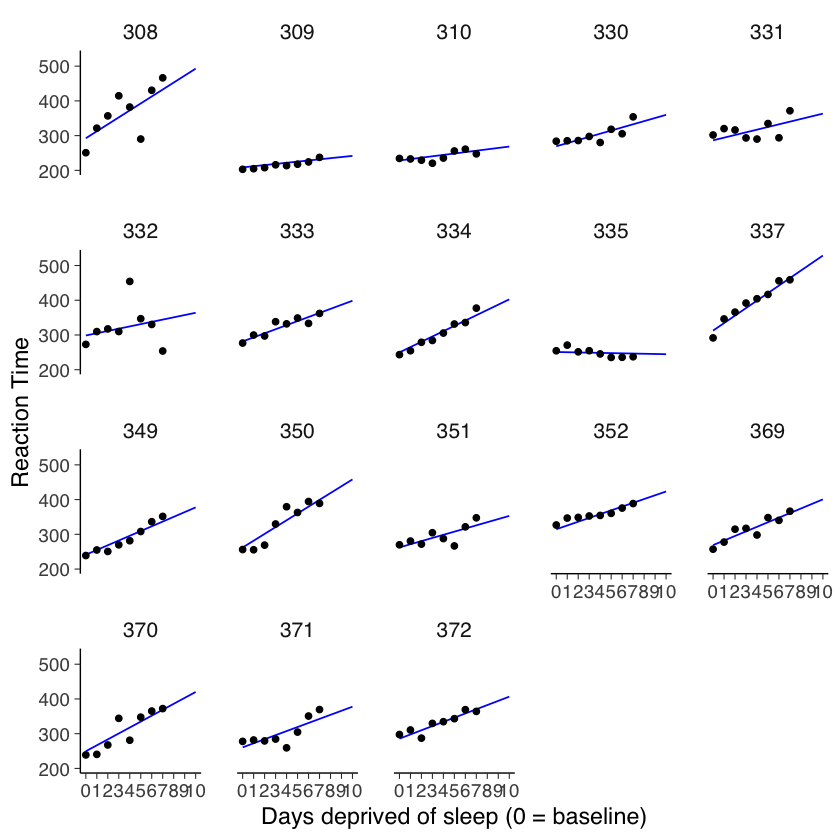

In [31]:
ggplot(sleep2, aes(x = days_deprived, y = Reaction)) +
    geom_line(
        data = bind_rows(newdata2, ndat),
        color = "blue"
    ) +
    geom_point() +
    scale_x_continuous(breaks = 0:10) +
    facet_wrap(~Subject) +
    labs(y = "Reaction Time", x = "Days deprived of sleep (0 = baseline)")

## Considerazioni Conclusive

Il presente capitolo presenta un'analisi approfondita dei modelli statistici multilivello discutendo l'esempio relativo all'effetto della deprivazione del sonno sulle prestazioni psicomotorie. Utilizzando il dataset `sleepstudy`, abbiamo introdotto concetti chiave quali "complete pooling", "no pooling" e "partial pooling". Questi approcci sono stati esplorati per evidenziare le loro implicazioni nella modellazione dei dati che contengono misure ripetute.

L'analisi si focalizza sull'applicazione pratica dei modelli multilivello, dettagliando le variabili fisse e casuali e la loro importanza nel contesto dei modelli. È stata posta particolare enfasi sulla matrice di varianza-covarianza, essenziale per comprendere le relazioni all'interno dei modelli multilivello.

I modelli multilivello sono di vitale importanza per l'assessment psicologico e la psicometria, in quanto permettono di analizzare dati complessi tenendo conto delle variazioni individuali e di gruppo. Questi modelli forniscono strumenti flessibili per esaminare l'influenza di fattori contestuali e individuali sul comportamento e le prestazioni psicologiche, un aspetto cruciale nell'assessment psicologico.

Il capitolo anticipa l'utilizzo dei modelli multilivello nel calcolo dell'affidabilità tra giudici, un tema che sarà approfondito nel capitolo successivo. Inoltre, i modelli multilivello sono presentati come un'introduzione o un'alternativa ai modelli di crescita latente, che verranno esplorati nei capitoli successivi. Questo collegamento sottolinea la continuità e l'importanza di tali modelli nell'ambito più ampio della ricerca psicologica e psicometrica.

## Session Info

In [71]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] kableExtra_1.4.0  repr_1.1.6        lme4_1.1-35.1     Matrix_1.6-5     
 [5] car_3.1-2         carData_3.0-5     rio_1.0.1         ggokabeito_0.1.0 
 [9] viridis_0.6.5     viridisLite_0.4.2 ggpubr_0.6.0      ggExtra_0.10.1   
[13] bayesplot_1.11.1  gridExtra_2.3     patchwork_1.2.0   semTools_0.5-6   
[17] semPlot_1.1.6     lavaan_0.6-17     psych_2.4.1       scales_1.3.0     
[21] markdown_1.12     knitr_1.45        lubridate_1.9.3   forcats_1.0.0    
[25] stringr_1.